In [1]:
import pandas as pd
import scipy.sparse
import joblib 


from sklearn.metrics import classification_report

# Creating db file from csv
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine # database connection
import sqlite3

from sklearn.model_selection import GridSearchCV


import os
import datetime as dt
from collections import Counter, defaultdict

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, log_loss, confusion_matrix

from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier




import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3
from sqlalchemy import create_engine # database connection

import math
import re
import datetime as dt
import time
import csv
import os

import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords


from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss

from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1> Machine Learning Models: XGBOOST </h1>

In [2]:
def xgboost_classifier(X_train, y_train):
    max_depth = np.array([3, 6, 9, 12, 15])
    learning_rate = np.array([0.01, 0.05, 0.1])
    n_estimators = np.array([20, 35, 50, 70, 100])
    params_dict = [{'max_depth': max_depth,'learning_rate': learning_rate,
                    'n_estimators': n_estimators}]
    xgb_optimal = XGBClassifier(random_state=1,n_jobs=6,
                                        class_weight='balanced')
    
    grid = GridSearchCV(estimator=xgb_optimal, 
                        param_grid=params_dict, 
                        scoring=log_loss, n_jobs=6, cv=3,
                        return_train_score=True)
    
    grid_result = grid.fit(X_train, y_train)
    train_auc = grid_result.cv_results_['mean_train_score']
    train_auc_std = grid_result.cv_results_['std_train_score']
    cv_auc = grid_result.cv_results_['mean_test_score']
    cv_auc_std = grid_result.cv_results_['std_test_score']
    
    print("Optimal Parameters : ", grid_result.best_estimator_.get_params())
        
    grid_param = grid_result.best_estimator_.get_params()
    return grid_param['max_depth'], grid_param['n_estimators'], grid_param['learning_rate'] 

In [3]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [4]:
def xgboost_applied(nlp_algo, ml_algo, X_train, Y_train, X_test, Y_test,  maxDepth, n_estimators,  learning_rate):
    # Setting up the classifier using optimal params

    xgb_optimal = XGBClassifier(max_depth=maxDepth,
                                learning_rate=learning_rate,
                                n_estimators=n_estimators,
                                n_jobs=6,class_weight='balanced',
                                random_state=1)
    
    # we have to fit the SGDClassifier so that we can access the coef_
    xgb_optimal.fit(X_train, Y_train)
    
    # Prediction on training and test set using optimal classifier
    logProb_train = xgb_optimal.predict_proba(X_train)
    logProb_test = xgb_optimal.predict_proba(X_test)
    pred_train = np.argmax(logProb_train, axis =1)
    pred_test = np.argmax(logProb_test, axis =1)
    print("Using max depth value for tree - ", maxDepth)
    print("Using num estimators for tree - ", n_estimators)

    
    print("Training Confusion Matrix")
    plot_confusion_matrix(Y_train, pred_train)
    
    print('\n\n')

    print("Test Confusion Matrix")
    plot_confusion_matrix(Y_train, pred_train)
    
    # Classification report 
    print(classification_report(Y_test, pred_test))
    
    print("Log loss on Test Data using Model", log_loss(y_test, pred_test, eps=1e-15))
    
    return xgb_optimal

## Applying tfidf model

In [5]:
# df_tfidf_full = joblib.load("models/01_nlp/05_full_tfidf_model_2000_datapoints.joblib") 
df_features_from_eda = pd.read_csv(r"data/03_all_features_from_eda.csv")

In [6]:
df_features_from_eda.head()

,Unnamed: 0,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,0,0,1,1,66,57,14,12,10.0,...,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100
1,1,1,0,4,1,51,88,8,13,4.0,...,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75
2,2,2,0,1,1,73,59,14,10,4.0,...,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47
3,3,3,0,1,1,50,65,11,9,0.0,...,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14
4,4,4,0,3,1,76,39,13,7,2.0,...,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56


In [7]:
# df_tfidf_full.shape

In [8]:
data_points = 10000

# df_tfidf_full = df_tfidf_full
# [:data_points]
df_features_from_eda = df_features_from_eda
# [:data_points]

Y = df_features_from_eda["is_duplicate"]
df_features_from_eda = df_features_from_eda.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1)

# df_tfidf_full.reset_index(drop=True, inplace=True)
# df_features_from_eda.reset_index(drop=True, inplace=True)

# X = pd.concat([df_features_from_eda, df_tfidf_full], axis=1)

X = df_features_from_eda 

print(X.shape)
print(Y.shape)

(404290, 25)
(404290,)


In [9]:
x_train,x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.3)

print("Number of data points in train data :",x_train.shape)
print("Number of data points in test data :",x_test.shape)

Number of data points in train data : (283003, 25)
Number of data points in test data : (121287, 25)


In [10]:
x_train.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
266290,2,2,86,40,15,7,5.0,22.0,0.227273,4,...,0.714276,0.333331,0.0,1.0,8.0,11.0,74,60,47,75
13978,4,1,54,46,11,8,5.0,19.0,0.263158,5,...,0.749991,0.545450,0.0,1.0,3.0,9.5,85,71,71,78
384613,1,1,285,124,60,27,14.0,65.0,0.215385,2,...,0.555553,0.241935,0.0,1.0,35.0,44.5,70,44,31,51
230060,2,2,22,30,4,5,1.0,9.0,0.111111,4,...,0.249994,0.199996,0.0,0.0,1.0,4.5,68,68,60,64
236717,1,1,14,43,3,8,0.0,11.0,0.000000,2,...,0.000000,0.000000,0.0,0.0,5.0,5.5,29,29,25,36


In [11]:
y_train.head()

54837     1
244232    0
293796    1
14284     1
299046    1
Name: is_duplicate, dtype: int64

In [12]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in train data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


Log loss on Test Data using Random Model 0.8880104466295633


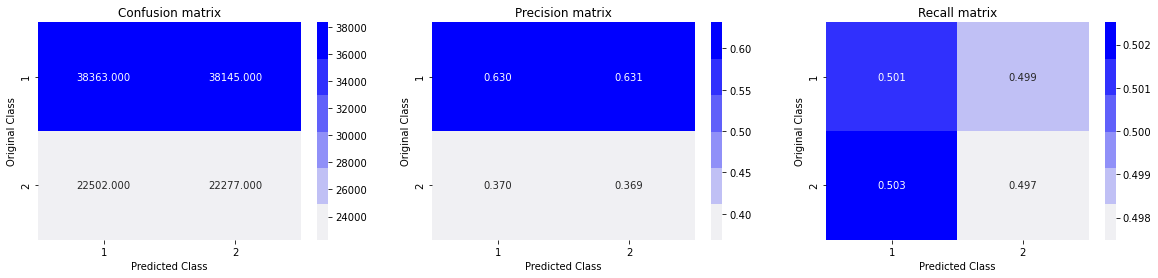

In [11]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model", log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [12]:
nlp_model = "TFIDF"
ml_model = "XGBOOST"

# # md: 'max_depth'  
# # ne: 'n_estimators'
# # lr:'learning_rate'

optimal_max_depth, optimal_n_estimator, optimal_learning_rate = xgboost_classifier(x_train, y_train)

[18:59:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:59:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Optimal Parameters :  {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.01,

[18:59:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:59:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Using max depth value for tree -  3
Using num estimators for tree -  20
Training Confusion Matrix


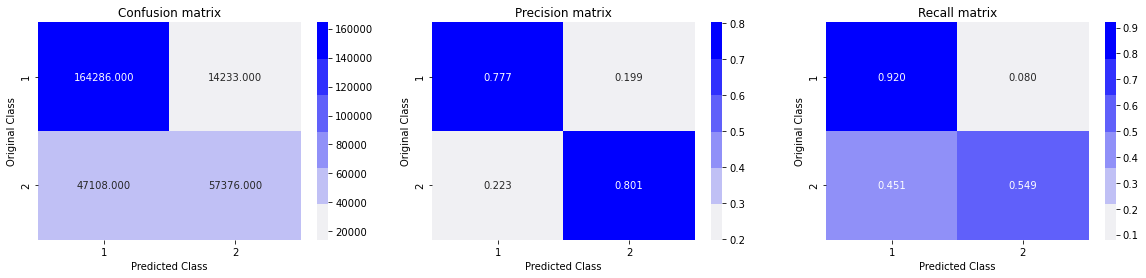




Test Confusion Matrix


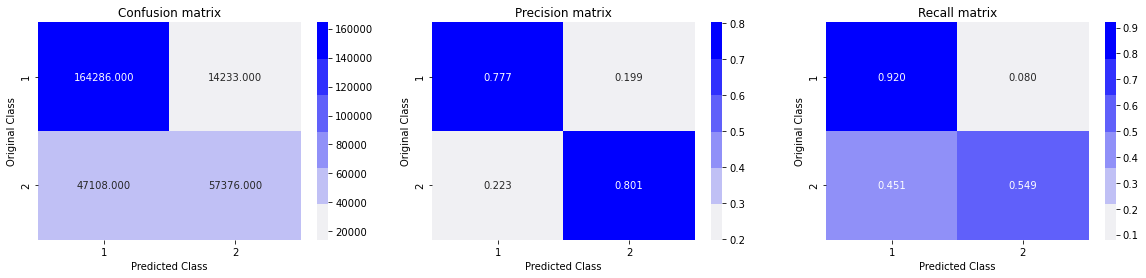

              precision    recall  f1-score   support

           0       0.78      0.92      0.84     76508
           1       0.80      0.55      0.65     44779

    accuracy                           0.78    121287
   macro avg       0.79      0.74      0.75    121287
weighted avg       0.79      0.78      0.77    121287

Log loss on Test Data using Model 7.441053059230332


In [14]:
model = xgboost_applied(nlp_model, ml_model,\
                   x_train, y_train, x_test, y_test,
                   optimal_max_depth, optimal_n_estimator, optimal_learning_rate)

In [15]:
joblib.dump(model, f"models/tfidf_xgboost_7.441053059230332_log_loss_v2.joblib")

['models/tfidf_xgboost_7.441053059230332_log_loss_v2.joblib']

## Applying tfidf weighted W2V model

In [5]:
df_tfidf_weighted_w2v_full = joblib.load(r"models/01_nlp/06_tfidf_weighted_w2v_2000_data_points.joblib") 
df_features_from_eda = pd.read_csv(r"data/03_all_features_from_eda_10000_data_points.csv")

In [6]:
# Less data points due low latency of my hardware 
data_points = 2000

df_tfidf_weighted_w2v_full = df_tfidf_weighted_w2v_full
# [:data_points]
df_features_from_eda = df_features_from_eda[:data_points]

Y = df_features_from_eda["is_duplicate"]
df_features_from_eda = df_features_from_eda.drop(['Unnamed: 0', 'is_duplicate'], axis=1)

df_tfidf_weighted_w2v_full.reset_index(drop=True, inplace=True)
df_features_from_eda.reset_index(drop=True, inplace=True)

X = pd.concat([df_features_from_eda, df_tfidf_weighted_w2v_full], axis=1)

print(X.shape)
print(Y.shape)

(2000, 218)
(2000,)


In [7]:
x_train,x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.3)

print("Number of data points in train data :",x_train.shape)
print("Number of data points in test data :",x_test.shape)

Number of data points in train data : (1400, 218)
Number of data points in test data : (600, 218)


In [8]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6292857142857143 Class 1:  0.3707142857142857
---------- Distribution of output variable in train data ----------
Class 0:  0.37166666666666665 Class 1:  0.37166666666666665


In [9]:
# nlp_model = "TFIDF WEIGHTED W2V"
# ml_model = "XGBOOST"

# # # md: 'max_depth'  
# # # ne: 'n_estimators'
# # # lr:'learning_rate'

# optimal_max_depth, optimal_n_estimator, optimal_learning_rate = xgboost_classifier(x_train, y_train)

In [10]:
nlp_model = "TFIDF WEIGHTED W2V"
ml_model = "XGBOOST"
optimal_max_depth = 4
optimal_n_estimator = 20
optimal_learning_rate =  0.01

[16:44:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:44:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Using max depth value for tree -  4
Using num estimators for tree -  20
Training Confusion Matrix


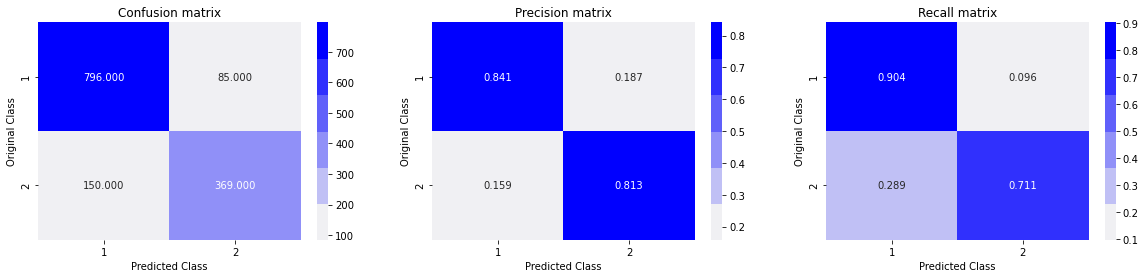




Test Confusion Matrix


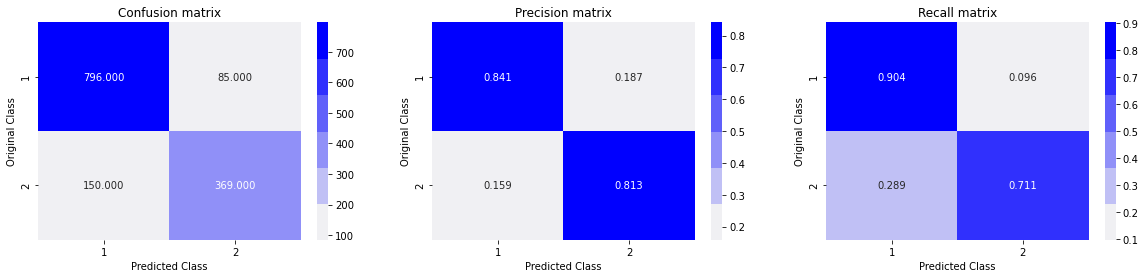

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       377
           1       0.75      0.58      0.66       223

    accuracy                           0.77       600
   macro avg       0.77      0.73      0.74       600
weighted avg       0.77      0.77      0.77       600

Log loss on Test Data using Model 7.828846620662253


In [11]:
model = xgboost_applied(nlp_model, ml_model,\
                   x_train, y_train, x_test, y_test,
                   optimal_max_depth, optimal_n_estimator, optimal_learning_rate)

In [12]:
joblib.dump(model, f"tfidf_weighted.joblib")

['tfidf_weighted.joblib']